#Fetching Image Data
1.Accessing data from our own google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading & Pre-processing image data


In [ ]:
#Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt


Set all the Constants


In [ ]:
BATCH_SIZE = 16
IMAGE_SIZE = 224
CHANNELS=3
EPOCHS=50

Import data into tensorflow dataset object


In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/crop-images/crop_images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 201 files belonging to 5 classes.


In [ ]:
class_names = dataset.class_names
class_names

['jute', 'maize', 'rice', 'sugarcane', 'wheat']

In [ ]:
len(dataset)

13

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(16, 224, 224, 3)
[0 0 4 4 0 1 1 1 1 1 0 3 1 0 2 0]


# Data visualization


Visualize some of the images from our dataset


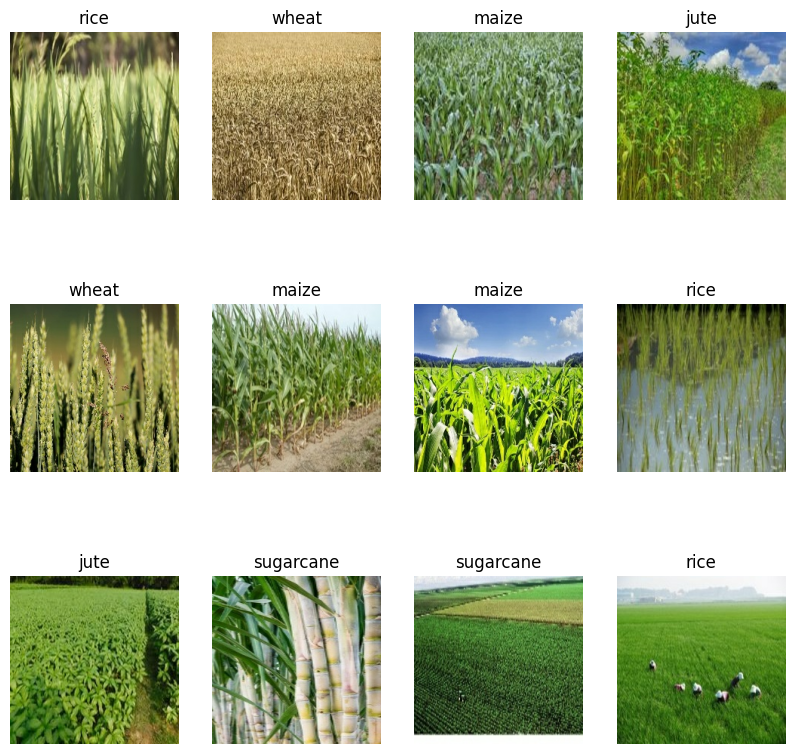

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# Split Dataset

In [ ]:
len(dataset)



13

In [ ]:
train_size = 0.7
len(dataset)*train_size

9.1

In [ ]:
train_ds = dataset.take(9)
len(train_ds)

9

In [ ]:
test_ds = dataset.skip(9)
len(test_ds)

4

In [ ]:
val_size=0.15
len(dataset)*val_size

1.95

In [ ]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [ ]:
test_ds = test_ds.skip(1)
len(test_ds)

3

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [ ]:
len(train_ds)


9

In [ ]:
len(val_ds)



1

In [ ]:
len(test_ds)



3

Cache, Shuffle, and Prefetch the Dataset


In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building the Model


Creating a Layer for Resizing and Normalization



In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

Data Augmentation


In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),

])

Applying Data Augmentation to Train Dataset


In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)


Model Architecture


In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [ ]:
model.summary()


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_9 (Sequential)   (16, 224, 224, 3)         0         
                                                                 
 conv2d_36 (Conv2D)          (16, 222, 222, 32)        896       
                                                                 
 max_pooling2d_36 (MaxPooli  (16, 111, 111, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_37 (Conv2D)          (16, 109, 109, 64)        18496     
                                                                 
 max_pooling2d_37 (MaxPooli  (16, 54, 54, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (16, 52, 52, 64)        

Compiling the Model


In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [ ]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
9/9 [==============================] - 76s 8s/step - loss: 1.6116 - accuracy: 0.1533 - val_loss: 1.6131 - val_accuracy: 0.1875
Epoch 2/50
9/9 [==============================] - 20s 2s/step - loss: 1.5985 - accuracy: 0.2482 - val_loss: 1.6202 - val_accuracy: 0.1875
Epoch 3/50
9/9 [==============================] - 22s 2s/step - loss: 1.5602 - accuracy: 0.2774 - val_loss: 1.7962 - val_accuracy: 0.1875
Epoch 4/50
9/9 [==============================] - 24s 3s/step - loss: 1.5757 - accuracy: 0.3723 - val_loss: 1.5322 - val_accuracy: 0.3750
Epoch 5/50
9/9 [==============================] - 25s 3s/step - loss: 1.4997 - accuracy: 0.3796 - val_loss: 1.4759 - val_accuracy: 0.3750
Epoch 6/50
9/9 [==============================] - 22s 2s/step - loss: 1.5485 - accuracy: 0.3504 - val_loss: 1.5599 - val_accuracy: 0.3125
Epoch 7/50
9/9 [==============================] - 21s 2s/step - loss: 1.4375 - accuracy: 0.3942 - val_loss: 1.4254 - val_accuracy: 0.3750
Epoch 8/50
9/9 [==================

In [ ]:
scores = model.evaluate(test_ds)


3/3 [==============================] - 3s 844ms/step - loss: 1.5405 - accuracy: 0.3542


In [ ]:
scores



[1.5404962301254272, 0.3541666567325592]

*loss*, accuracy

In [ ]:
history.params


{'verbose': 1, 'epochs': 50, 'steps': 9}

In [ ]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
type(history.history['loss'])


list

In [ ]:
len(history.history['loss'])


50

In [ ]:
history.history['loss'][:5] # show loss for first 5 epochs


[1.6115778684616089,
 1.59852933883667,
 1.5601967573165894,
 1.5757040977478027,
 1.4996873140335083]

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

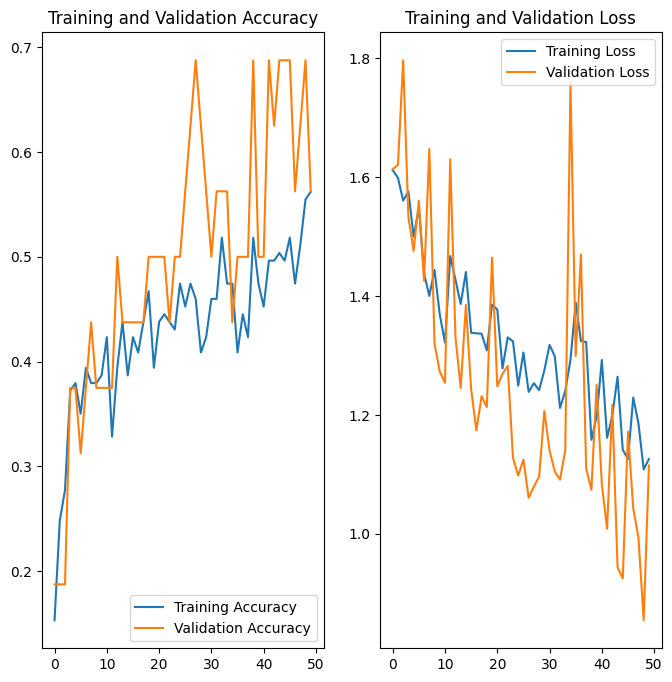

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

*Prediction*


first image to predict
actual label: jute
1/1 [==============================] - 1s 559ms/step
predicted label: jute


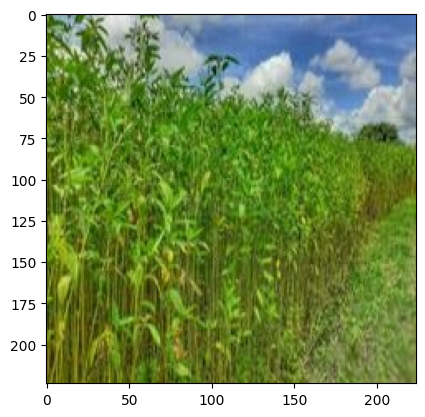

In [ ]:
#on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
#on few sample images
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence


1/1 [==============================] - 0s 44ms/step


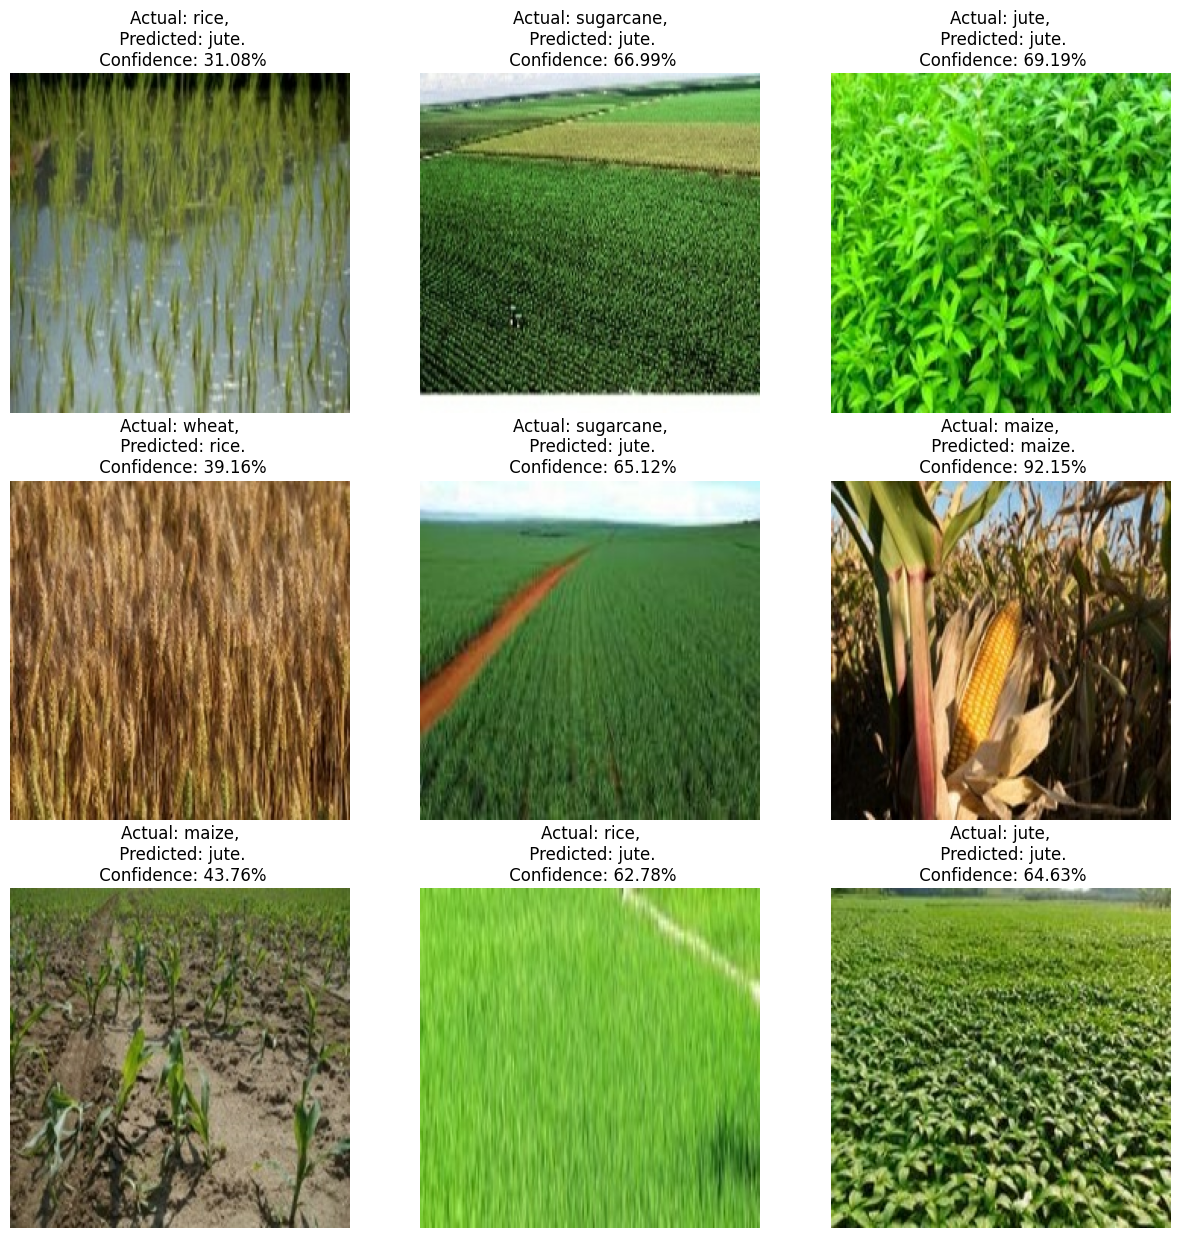

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")